In [1]:
!git clone https://github.com/AndreyK2001/BERT-Classification

fatal: destination path 'BERT-Classification' already exists and is not an empty directory.


In [40]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification
import pandas as pd
import numpy as np

df = pd.read_csv('/content/BERT-Classification/data_ru.txt')
df.head()

,textid,text,class
0,20151029radar,ВВС Франции провели испытания перспективной па...,Easy
1,20161212aggressive-drones,Исследователи из Цюрихского университета научи...,Easy
2,20161212aggressive-drones,собственных датчиков для оперативного ориентир...,Easy
3,20150826twinjet-hubble,Орбитальная обсерватория «Хаббл» получил новые...,Very Easy
4,20150826shining-solved-profile,"Ученые из Бостона выяснили, что практически вс...",Normal


In [41]:
df['class'].value_counts()

Easy         5420
Very Easy    2045
Normal       1700
Hard          436
Very Hard     156
Name: class, dtype: int64

In [42]:
#possible_labels = df['class'].unique()

#label_dict = {}
#for index, possible_label in enumerate(possible_labels):
#    label_dict[possible_label] = index
#label_dict
label_dict = {'Very Easy': 0, 'Easy': 1, 'Normal': 2,'Hard': 3, 'Very Hard': 4}

In [43]:
df['label'] = df['class'].replace(label_dict)

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                  df.label.values,
                                                  test_size=0.15,
                                                  stratify=df.label.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['class', 'label', 'data_type']).count().sort_values(['label'])

textid  text
class     label data_type              
Very Easy 0     train        1738  1738
                val           307   307
Easy      1     train        4607  4607
                val           813   813
Normal    2     train        1445  1445
                val           255   255
Hard      3     train         370   370
                val            66    66
Very Hard 4     train         133   133
                val            23    23

In [45]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [46]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

In [48]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [50]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        tqdm.write(f'Class: {label_dict_inverse[label]}')
        tqdm.write(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

def plot_confusion_matrix(preds, labels, label_dict):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    label_to_name = {value: key for key, value in label_dict.items()}

    # Вычисляем confusion matrix
    cm = confusion_matrix(labels_flat, preds_flat)
    label_names = ['Very Easy', 'Easy', 'Normal', 'Hard', 'Very Hard']#[label_to_name.get(label, "Unknown") for label in np.unique(labels_flat)]

    # Визуализация confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm[::-1], annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names[::-1])
    plt.title('Confusion Matrix')
    plt.ylabel('Истинные классы')
    plt.xlabel('Предсказанные классы')
    plt.show()


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2765 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.9676882489949842
Validation loss: 0.8671997983283439
F1 Score (Weighted): 0.6292044979202251


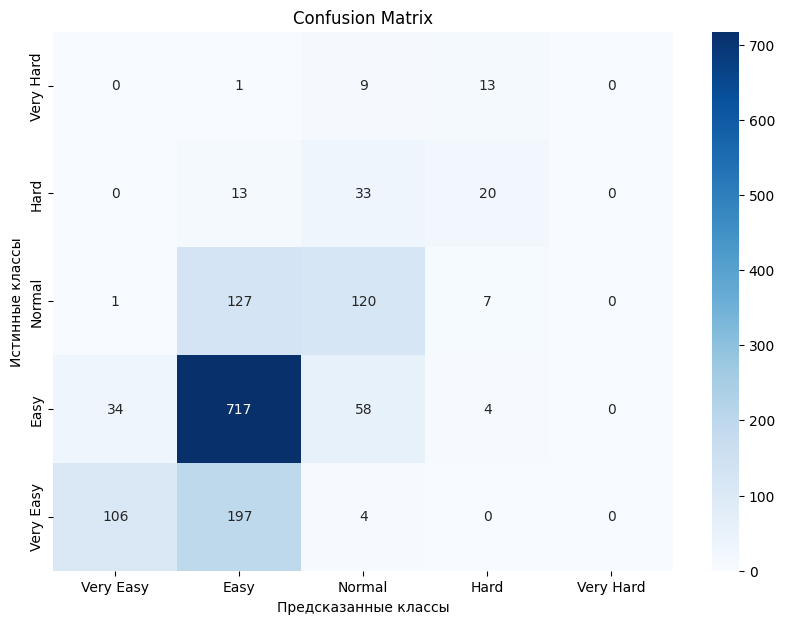

Epoch 2:   0%|          | 0/2765 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.8555392700404091
Validation loss: 0.9481495403394592
F1 Score (Weighted): 0.6316959501169304


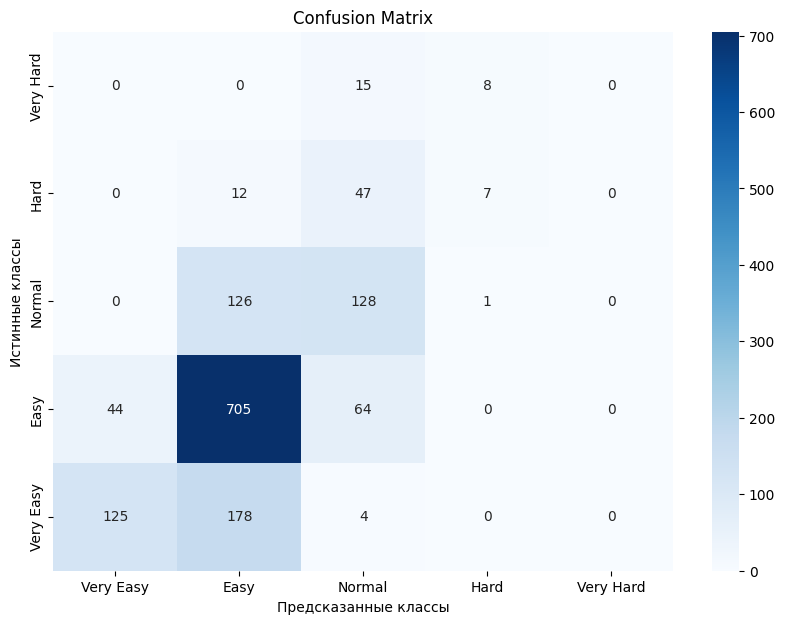

Epoch 3:   0%|          | 0/2765 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.805423653694998
Validation loss: 1.0682284127936135
F1 Score (Weighted): 0.6165030794340403


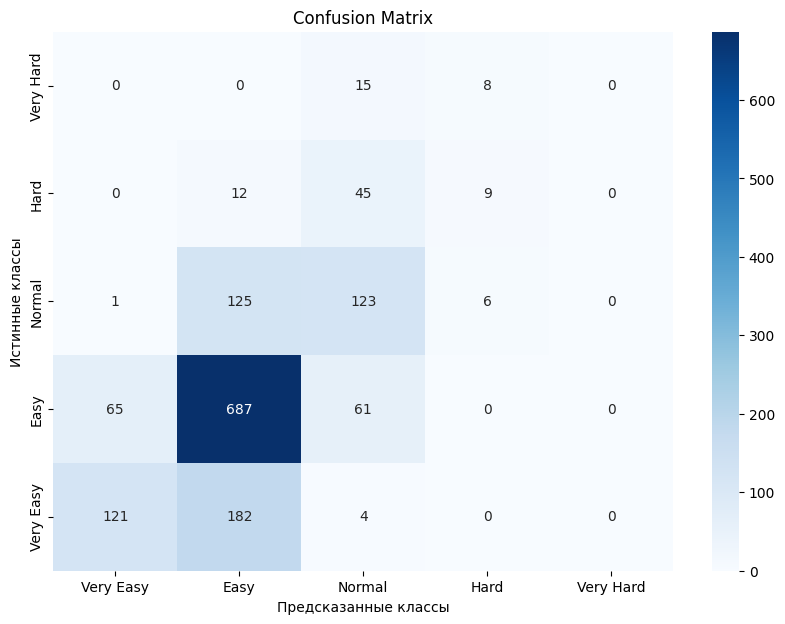

Epoch 4:   0%|          | 0/2765 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [51]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = 'cuda'

model = model.to(device)

def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})



    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    #accuracy_per_class(predictions, true_vals)
    plot_confusion_matrix(predictions, true_vals, label_dict)

In [ ]:
torch.save(model.state_dict(), './ru_classsifier.model')

In [52]:
df = pd.read_csv('/content/BERT-Classification/data_en.txt')
df.head()

,text,class
0,BOOK ASteve Martin's Compelling Evidence is co...,Hard
1,a legendary film star's daughter. The author's...,Hard
2,Tapping into a food supplyIn the forests of Ma...,Hard
3,"smelling or hearing the insects, how were the ...",Hard
4,THE DAY I GAVE UP SMOKINGI thought everyone wo...,Hard


In [53]:
df['class'].value_counts()

Hard         207
Very Hard    203
Normal       185
Easy          79
Very Easy     64
Name: class, dtype: int64

In [54]:
df['label'] = df['class'].replace(label_dict)

In [55]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',
                                          do_lower_case=True)

encoded_data_predict = tokenizer.batch_encode_plus(
    df.text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [56]:
input_ids_predict = encoded_data_predict['input_ids']
attention_masks_predict = encoded_data_predict['attention_mask']
labels_predict = torch.tensor(df.label.values)

In [57]:
dataset_predict = TensorDataset(input_ids_predict, attention_masks_predict, labels_predict)

In [58]:
batch_size = 3

dataloader_predict = DataLoader(dataset_predict,
                              sampler=RandomSampler(dataset_predict),
                              batch_size=batch_size)

Predictions loss: 4.517242309039201
F1 Score (Weighted): 0.04249542538006141


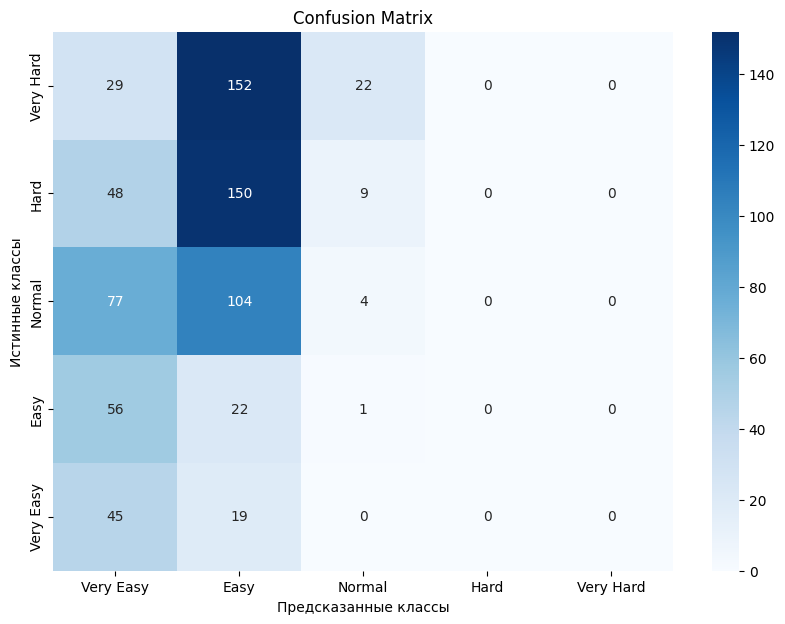

In [60]:
predict_loss, predictions, true_predict = evaluate(dataloader_predict)
predict_f1 = f1_score_func(predictions, true_predict)
print(f'Predictions loss: {predict_loss}')
print(f'F1 Score (Weighted): {predict_f1}')
plot_confusion_matrix(predictions, true_predict, label_dict)
